# Data Undetstanding

In [143]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Step 1: Load the dataset (replace with your actual data file path)
df = pd.read_csv('retail_store_inventory.csv')

# Step 2: Convert Date Column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Step 3: Convert boolean columns to integers (1 for True, 0 for False)
boolean_columns = ['Holiday/Promotion']
df[boolean_columns] = df[boolean_columns].astype(int)

# Step 4: Handle categorical columns (use One-Hot Encoding or Label Encoding)
df = pd.get_dummies(df, columns=['Store ID', 'Product ID', 'Category', 'Region', 'Weather Condition', 'Seasonality'], drop_first=True)

# Step 5: Drop any irrelevant or unnecessary columns
df = df.drop(columns=['Date', 'Units Ordered', 'Demand Forecast'])  # Dropping columns that aren't directly used for prediction

# Step 6: Define Features (X) and Target (y)
X = df.drop(columns=['Units Sold'])  # Features (all columns except target)
y = df['Units Sold']  # Target variable (Units Sold)

# Step 7: Scale the Numerical Data (using MinMaxScaler)
scaler = MinMaxScaler()
numerical_columns = ['Inventory Level', 'Price', 'Discount', 'Competitor Pricing']  # Example numerical columns

# Scale only the numerical columns
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# Step 8: Create Sliding Window for Time Series (window_size = 14)
window_size = 14
X_seq, y_seq = [], []

for i in range(window_size, len(X)):
    X_seq.append(X.iloc[i - window_size:i].values)  # Last 14 days as input for each sample
    y_seq.append(y.iloc[i])  # Target variable (Units Sold) for the next day

# Convert to numpy arrays
X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# Step 9: Train-Test Split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# Reshape the data for LSTM (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))  # [samples, timesteps, features]
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))  # [samples, timesteps, features]

# Step 10: Ensure the columns are numeric (handle potential non-numeric data)
# Convert to numeric and replace non-numeric values with NaN
X_train = np.array(X_train, dtype=float)
X_test = np.array(X_test, dtype=float)

# Handle NaN values by replacing them with 0 (or any strategy you prefer)
X_train = np.nan_to_num(X_train, nan=0)  # Replace NaN with 0
X_test = np.nan_to_num(X_test, nan=0)    # Replace NaN with 0

# Step 11: Ensure the target is numeric (convert to float)
y_train = y_train.astype(float)
y_test = y_test.astype(float)

# Step 12: Build the LSTM Model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=128))
    model.add(Dropout(0.2))
    model.add(Dense(1))  # Output layer for predicting 'Units Sold' for the next day
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Build the model
model = build_lstm_model((X_train.shape[1], X_train.shape[2]))  # Define input shape based on the number of timesteps and features

# Step 13: Train the Model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Step 14: Predict and Inverse Transform the Results (for evaluating the actual prediction amount)
y_pred = model.predict(X_test)

/Users/xiaoming/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 32s 17ms/step - loss: 19023.5996 - val_loss: 11735.2402
Epoch 2/100
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 33s 18ms/step - loss: 11881.7529 - val_loss: 11725.8564
Epoch 3/100
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - loss: 11962.0264 - val_loss: 11727.2930
Epoch 4/100
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - loss: 11834.5752 - val_loss: 11727.0645
Epoch 5/100
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - loss: 11866.8203 - val_loss: 11726.7217
Epoch 6/100
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - loss: 12015.4678 - val_loss: 11725.9785
Epoch 7/100
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - loss: 11892.5068 - val_loss: 11725.3096
Epoch 8/100
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - loss: 11899.5000 - val_loss: 11725.4336
Epoch 9/100
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - loss: 11919.2188 - val_loss: 11725.8164
Epoch 10/100
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - loss: 11944.9648 - val_loss: 11726.1182
Epoch 11/

ValueError: non-broadcastable output operand with shape (14618,1) doesn't match the broadcast shape (14618,4)

In [145]:
# Step 1: Scale features (only for X_train and X_test)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[1]))  # Only scale features
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[1]))  # Use the same scaling as for training

# Step 2: Reshape the data to 3D for LSTM (samples, timesteps, features)
# Assuming your model expects the input in the shape (samples, timesteps, features)
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 14, X_train_scaled.shape[1]))  # Reshape with 14 timesteps
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 14, X_test_scaled.shape[1]))  # Reshape with 14 timesteps

# Step 3: Make predictions on the test set with the LSTM model
y_pred = model.predict(X_test_scaled)

# Step 4: Inverse transform only the predicted target values
y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1))  # Inverse transform predicted target
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))    # Inverse transform actual target

# Flatten to 1D arrays for easier comparison
y_pred_original = y_pred_original.flatten()
y_test_original = y_test_original.flatten()

# Step 5: Calculate RMSE (Root Mean Squared Error) and MAE (Mean Absolute Error)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mae = mean_absolute_error(y_test_original, y_pred_original)

print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'Mean Absolute Error (MAE): {mae:.2f}')

ValueError: cannot reshape array of size 33560632 into shape (2397188,14,14)

In [149]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv('retail_store_inventory.csv')

# Convert date to datetime and extract features
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

# Handle categorical variables
categorical_cols = ['Store ID', 'Product ID', 'Category', 'Region', 'Weather Condition', 'Seasonality']
df = pd.get_dummies(df, columns=categorical_cols)

# Select relevant features and target
features = df.drop(['Units Sold', 'Date'], axis=1)
target = df['Units Sold']

# Normalize the data
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(target.values.reshape(-1, 1))

In [150]:
def create_sequences(features, target, time_steps=10):
    X, y = [], []
    for i in range(len(features) - time_steps):
        X.append(features[i:(i + time_steps)])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 10  # Number of previous time steps to use for prediction
X, y = create_sequences(scaled_features, scaled_target, time_steps)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [151]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Model parameters
n_features = X_train.shape[2]  # Number of features

model = Sequential([
    LSTM(100, activation='relu', input_shape=(time_steps, n_features)),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

model.summary()

/Users/xiaoming/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 100)            │        61,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,301 (258.99 KB)

 Trainable params: 66,301 (258.99 KB)

 Non-trainable params: 0 (0.00 B)

In [152]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.0516 - mae: 0.1832 - val_loss: 0.0475 - val_mae: 0.1781
Epoch 2/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0482 - mae: 0.1788 - val_loss: 0.0477 - val_mae: 0.1808
Epoch 3/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0478 - mae: 0.1786 - val_loss: 0.0475 - val_mae: 0.1779
Epoch 4/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0482 - mae: 0.1794 - val_loss: 0.0475 - val_mae: 0.1777
Epoch 5/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0480 - mae: 0.1790 - val_loss: 0.0475 - val_mae: 0.1784
Epoch 6/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0476 - mae: 0.1780 - val_loss: 0.0475 - val_mae: 0.1784
Epoch 7/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0474 - mae: 0.1782 - val_loss: 0.0476 - val_mae: 0.1782
Epoch 8/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0469 - mae: 0.1766 - val_loss: 0.0478 - val_mae: 0.1798
Epoch 9/50
1828/1828 ━━━━━━━━━━━━━━━━━━

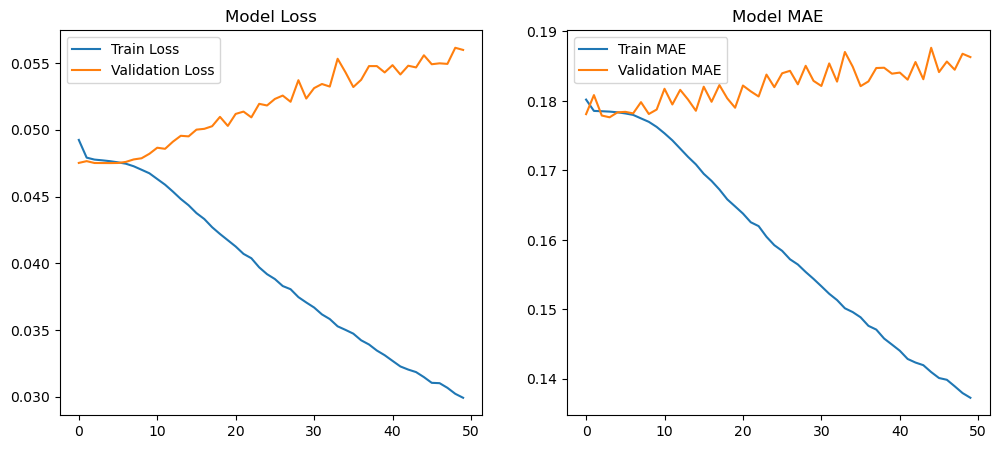

Test Loss: 0.0560
Test MAE: 0.1863


In [153]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.legend()
plt.show()

# Evaluate on test set
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

457/457 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


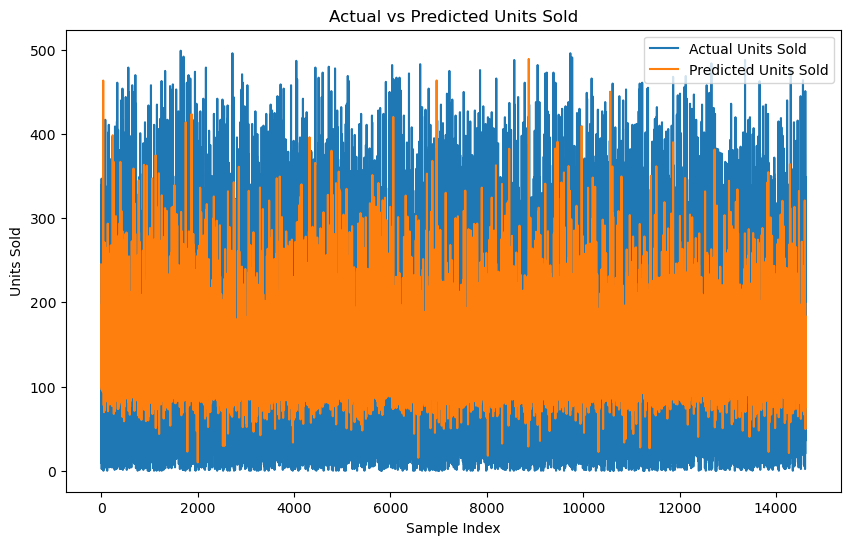

In [154]:
# Make predictions
predictions = model.predict(X_test)

# Inverse transform the scaling
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
predictions_inv = scaler.inverse_transform(predictions)

# Plot predictions vs actual
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Actual Units Sold')
plt.plot(predictions_inv, label='Predicted Units Sold')
plt.title('Actual vs Predicted Units Sold')
plt.xlabel('Sample Index')
plt.ylabel('Units Sold')
plt.legend()
plt.show()

In [156]:
%pip install --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load the dataset
data = pd.read_csv('retail_store_inventory.csv')

# Convert Date to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Prepare feature columns and target column
features = data[['Date', 'Product ID', 'Units Ordered', 'Price', 'Discount', 'Weather Condition', 'Seasonality', 'Holiday/Promotion', 'Competitor Pricing', 'Inventory Level']]
target = data['Demand Forecast']

# Convert 'Date' to numeric format (timestamp in seconds)
features['Date'] = features['Date'].astype(int) / 10**9

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Define preprocessing pipeline for numerical and categorical columns
numerical_columns = ['Units Ordered', 'Price', 'Discount', 'Competitor Pricing', 'Inventory Level']
categorical_columns = ['Weather Condition', 'Seasonality', 'Holiday/Promotion', 'Product ID']

# Preprocessing pipeline: numerical features -> imputation + scaling, categorical -> imputation + one-hot encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', MinMaxScaler())]), numerical_columns),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))]), categorical_columns)
    ])

# Apply the preprocessing pipeline
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Normalize the target variable (Demand Forecast)
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

# Check the shape of processed data
print(X_train_processed.shape, y_train_scaled.shape)

(58480, 31) (58480, 1)


/var/folders/4t/djwvd9x56pbd7jvyyp8cbw6w0000gn/T/ipykernel_73389/2811328228.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['Date'] = features['Date'].astype(int) / 10**9


Epoch 1/20


/Users/xiaoming/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1828/1828 ━━━━━━━━━━━━━━━━━━━━ 2s 736us/step - loss: 0.0374 - val_loss: 0.0284
Epoch 2/20
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 1s 743us/step - loss: 0.0282 - val_loss: 0.0288
Epoch 3/20
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 1s 597us/step - loss: 0.0282 - val_loss: 0.0286
Epoch 4/20
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 1s 589us/step - loss: 0.0281 - val_loss: 0.0284
Epoch 5/20
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 1s 598us/step - loss: 0.0282 - val_loss: 0.0283
Epoch 6/20
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0280 - val_loss: 0.0283
Epoch 7/20
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 1s 594us/step - loss: 0.0278 - val_loss: 0.0284
Epoch 8/20
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 1s 743us/step - loss: 0.0279 - val_loss: 0.0286
Epoch 9/20
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 1s 592us/step - loss: 0.0278 - val_loss: 0.0287
Epoch 10/20
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 1s 590us/step - loss: 0.0280 - val_loss: 0.0285
Epoch 11/20
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 1s 601us/step - loss: 0.0279 - val_loss: 0.0284
Epoch 12/20
1828/1828

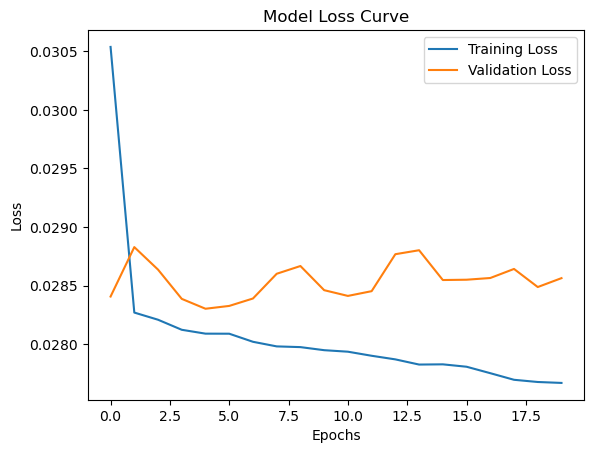

In [3]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Convert sparse matrices to dense format
X_train_processed_dense = X_train_processed.toarray()  # Convert to dense matrix
X_test_processed_dense = X_test_processed.toarray()  # Convert to dense matrix

# Reshape data to be in the form (samples, time_steps, features) for LSTM
# Here we assume time_steps = 1 for simplicity, as we don't have time-series sequences in the data
X_train_reshaped = X_train_processed_dense.reshape((X_train_processed_dense.shape[0], 1, X_train_processed_dense.shape[1]))
X_test_reshaped = X_test_processed_dense.reshape((X_test_processed_dense.shape[0], 1, X_test_processed_dense.shape[1]))

# Build the LSTM model
model = Sequential()

# Add LSTM layer with 50 units and input shape
model.add(LSTM(units=50, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))

# Add a Dense layer for output prediction
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model on the training data
history = model.fit(X_train_reshaped, y_train_scaled, epochs=20, batch_size=32, validation_data=(X_test_reshaped, y_test_scaled), verbose=1)

# Predict the demand forecast using the trained model
y_pred_scaled = model.predict(X_test_reshaped)

# Inverse transform to get the actual predicted demand values
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test_scaled)

# Calculate MAE and RMSE for evaluation
mae = mean_absolute_error(y_test_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))

# Print evaluation metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plot the loss curve during training
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [6]:
%pip install keras-tuner

Note: you may need to restart the kernel to use updated packages.


In [2]:
import keras_tuner as kt
from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential

# Define a function to build the model with tunable hyperparameters
def build_model(hp):
    model = Sequential()
    
    # LSTM layer with tunable units
    model.add(LSTM(units=hp.Int('units', min_value=50, max_value=200, step=50), 
                   activation='relu', 
                   input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
    
    # Dropout layer to avoid overfitting
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    
    # Output layer
    model.add(Dense(units=1))
    
    # Compile the model with a tunable optimizer
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
                  loss='mean_squared_error')
    
    return model

# Initialize the tuner using Hyperband
tuner = kt.Hyperband(build_model,
                     objective='val_loss',
                     max_epochs=20,
                     factor=3,
                     directory='my_dir',
                     project_name='demand_forecast')

# Start the search for the best hyperparameters
tuner.search(X_train_reshaped, y_train_scaled, epochs=20, batch_size=32, validation_data=(X_test_reshaped, y_test_scaled))

# Get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best Hyperparameters: {best_hyperparameters.values}")

# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hyperparameters)

# Fit the best model
history = best_model.fit(X_train_reshaped, y_train_scaled, epochs=20, batch_size=32, validation_data=(X_test_reshaped, y_test_scaled))

# Evaluate the model
y_pred_scaled_best = best_model.predict(X_test_reshaped)

# Inverse transform to get the actual predicted demand values
y_pred_best = scaler.inverse_transform(y_pred_scaled_best)
mae_best = mean_absolute_error(y_test_actual, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test_actual, y_pred_best))

print(f"Best MAE: {mae_best}")
print(f"Best RMSE: {rmse_best}")

NameError: name 'X_train_reshaped' is not defined